In [1]:
import pandas as pd
import numpy as np
import gc
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### 1 - Labels

- 458913 labels, no NA values and duplicated customer IDs
- 0 stands for good customer(no default), 1 stands for bad customer(default)
- 340,085 good customers and 118,828 bad customers in our dataset
- After up sampling 20x for good customer, in the real scenario around 98.2% is good customer and 1.71% are bad customer

#### insights
- The classes are imbalanced. A StratifiedKFold for cross-validation is recommended.
- Because the classes are imbalanced, accuracy would be a bad metric to evaluate a classifier. The competition metric is a mix of area under the roc curve (auc) and recall.

In [2]:
train_y = pd.read_csv('./data/amex-default-prediction/train_labels.csv')

train_y.head(2)

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0


In [3]:
train_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458913 entries, 0 to 458912
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_ID  458913 non-null  object
 1   target       458913 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [4]:
train_y.customer_ID.duplicated().any()

False

In [5]:
label_stats = pd.DataFrame({'absolute': train_y.target.value_counts(),
                            'relative': train_y.target.value_counts() / len(train_y)})
label_stats['absolute upsampled'] =  label_stats.absolute * np.array([20, 1])
label_stats['relative upsampled'] = label_stats['absolute upsampled'] / label_stats['absolute upsampled'].sum()
label_stats

,absolute,relative,absolute upsampled,relative upsampled
0,340085,0.741066,6801700,0.98283
1,118828,0.258934,118828,0.01717


## 2 - Data

- The data has been resize and use feather format - training and testing are now only 2.2 ang 4.4 GB
- Through info function we know that lots of columns have NA values


### Insights
- Need to be careful when play around with huge amount of data, use del and gc function if necessary
- Need to handle NA value but using global average may not be the best solution, customer level average could be better

In [6]:
# loading training and testing features
train_x = pd.read_feather('./data/train_x.feather')
test_x = pd.read_feather('./data/test_x.feather')

print(train_x.shape, test_x.shape)

(5531451, 190) (11363762, 190)


In [7]:
train_x.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216


In [8]:
test_x.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631348,0.001912,0.010727,0.814453,0.007545,0.168701,0.009972,0.002348,...,NaN,NaN,NaN,NaN,0.004669,NaN,NaN,NaN,0.008278,NaN
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.586914,0.005276,0.011024,0.811035,0.001817,0.241333,0.000166,0.009132,...,NaN,NaN,NaN,0.000142,0.004940,0.009018,NaN,0.003695,0.003754,0.00146


In [9]:
print(f"train x is using {train_x.memory_usage().sum() / 1e9} GBytes")
print(f"test x is using {test_x.memory_usage().sum() / 1e9} GBytes")

train x is using 2.229174881 GBytes
test x is using 4.579596214 GBytes


In [27]:
train_x.info(max_cols=200, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #    Column       Non-Null Count    Dtype  
---   ------       --------------    -----  
 0    customer_ID  5531451 non-null  object 
 1    S_2          5531451 non-null  object 
 2    P_2          5485466 non-null  float16
 3    D_39         5531451 non-null  float16
 4    B_1          5531451 non-null  float16
 5    B_2          5529435 non-null  float16
 6    R_1          5531451 non-null  float16
 7    S_3          4510907 non-null  float16
 8    D_41         5529435 non-null  float16
 9    B_3          5529435 non-null  float16
 10   D_42         791314 non-null   float16
 11   D_43         3873055 non-null  float16
 12   D_44         5257132 non-null  float16
 13   B_4          5531451 non-null  float16
 14   D_45         5529434 non-null  float16
 15   B_5          5531451 non-null  float16
 16   R_2          5531451 non-null  float16
 17   D_46         4319752 non-

### 2.1 Date columns

### Fact
- S_2 is date columns stands for when the statement is happen
- No NA value for date column(S_2) - according previous dataframe info
- Train date start from 2017-03-01 to 2018-03-31, 13 months
- Test date start from 2018-04-01 to 2019-10-31, 19 months


In [28]:
print(f"train_x date is from {train_x.S_2.min()} to {train_x.S_2.max()}")
print(f"test_x date is from {test_x.S_2.min()} to {test_x.S_2.max()}")

train_x date is from 2017-03-01 to 2018-03-31
test_x date is from 2018-04-01 to 2019-10-31


### Fact

- For train data set March 2017, April 2017, Sep 2017, Oct 2017, Feb 2018 and March 2018 have more data compared with other month
- For testing data set Feb 2019 to March 2019 and Oct 2018 to Jan 2019 have more data compared with other month
- For both training and testing data some clients don't have statement data in certain month
- Most of clients have 13 statement in both training and testing dataset

### Insights
- Because we are missing some statements for certain clients during the middle, it may not be a good ideal to use time seriers model, cause it will complexity to handle missing statement

<AxesSubplot:>

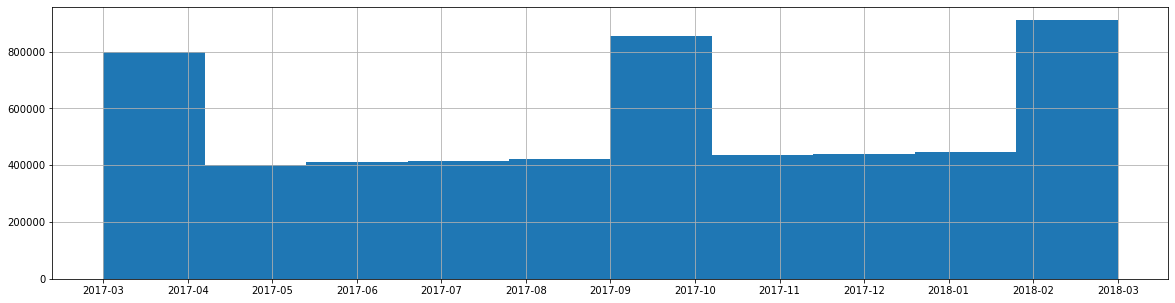

In [47]:
# plot histgram for date columns - training data
train_x['S_2'].str.slice(0 ,7).hist(figsize=(20, 5))

<AxesSubplot:>

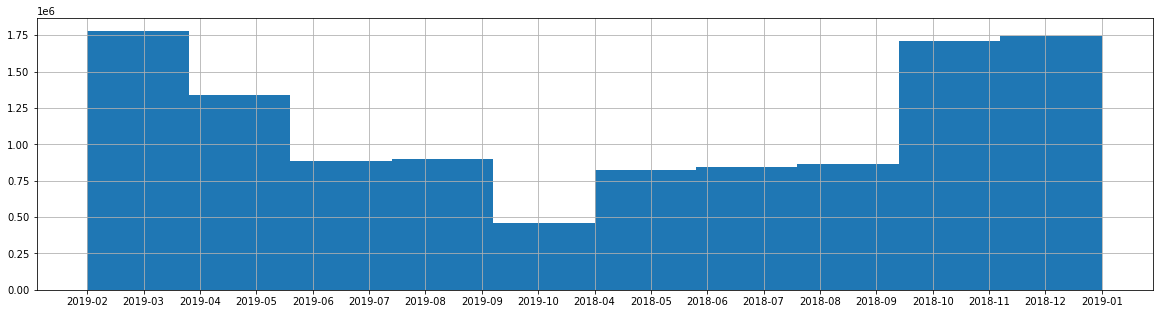

In [48]:
# plot histgram for date columns - testing data
test_x['S_2'].str.slice(0 ,7).hist(figsize=(20, 5))

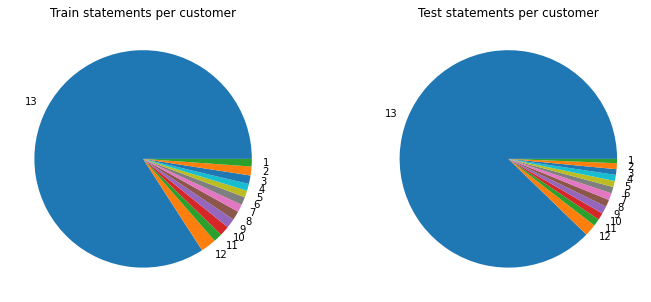

In [49]:
# plot pie chart for training and testing statements
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
train_sc = train_x.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Train statements per customer')
ax1.pie(train_sc, labels=train_sc.index)
ax1.set_title(train_sc.name)
test_sc = test_x.customer_ID.value_counts().value_counts().sort_index(ascending=False).rename('Test statements per customer')
ax2.pie(test_sc, labels=test_sc.index)
ax2.set_title(test_sc.name)
plt.show()

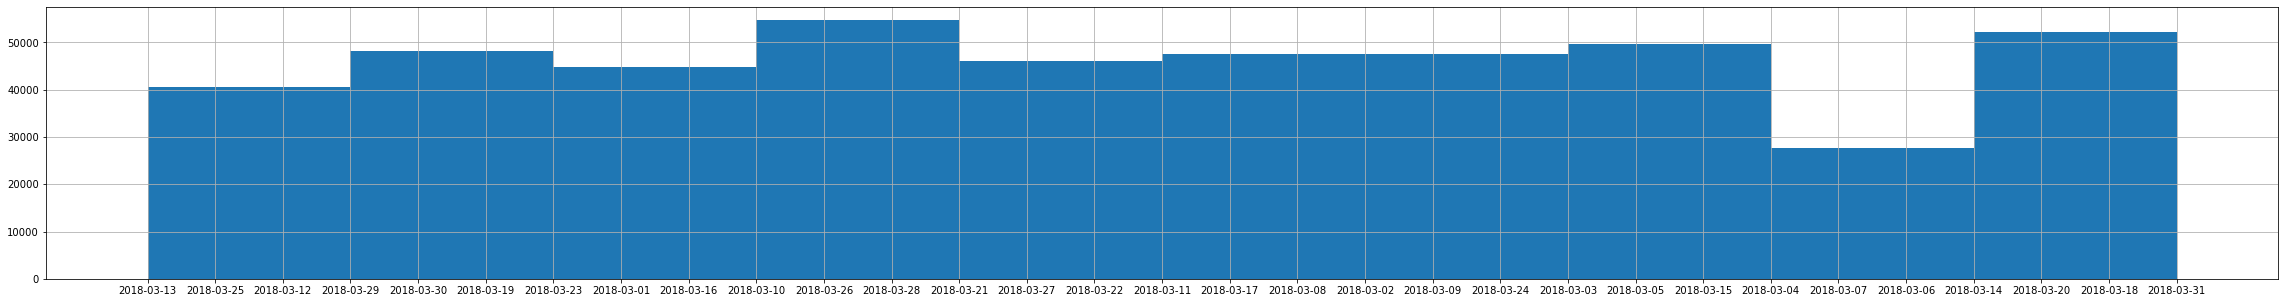

In [60]:
# when did customer get their final statments - training
temp = train_x.S_2.groupby(train_x.customer_ID).max()
temp.reset_index()['S_2'].hist(figsize=(40, 5))
del temp

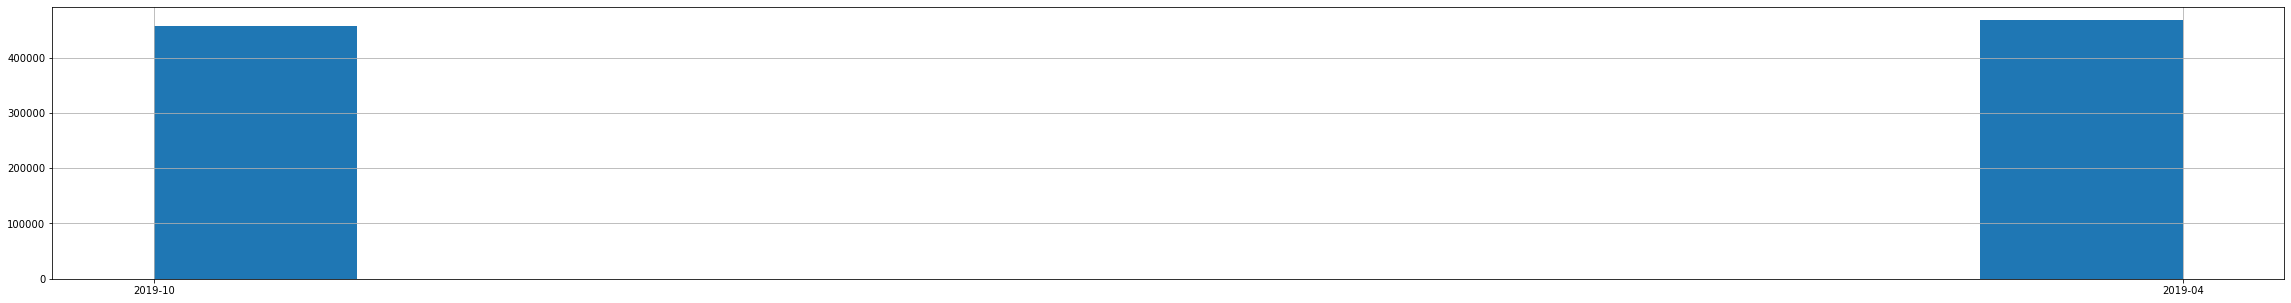

In [62]:
# when did customer get their final statments - testing
temp = test_x.S_2.groupby(test_x.customer_ID).max()
temp.reset_index()['S_2'].str.slice(0 ,7).hist(figsize=(40, 5))
del temp

### 2.2 Categorical features

#### Fact
- 11 categorical features provided by offical and 2 more binary features can be found
- 'B_30','B_38','D_114','D_117','D_64','D_68' histgram for 0 and 1 is not same
- 'D_116', 'D_126', 'D_120', 'D_63','D_66', 'B_31' histgram for 0 and 1 is almost same
-  D_87 most value is NA

#### Insights
- category feature like 'B_30','B_38','D_114','D_117','D_64','D_68' can provide useful info
- category feature like 'D_116', 'D_126', 'D_120', 'D_63','D_66', 'B_31' may not be able to provide useful info
- binary feature D_87 can be dropped, since most value is NA


In [65]:
# join labels with train_x
train = pd.merge(train_x, train_y, on=['customer_ID'], how='inner')
del train_x
train.head(2)

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0


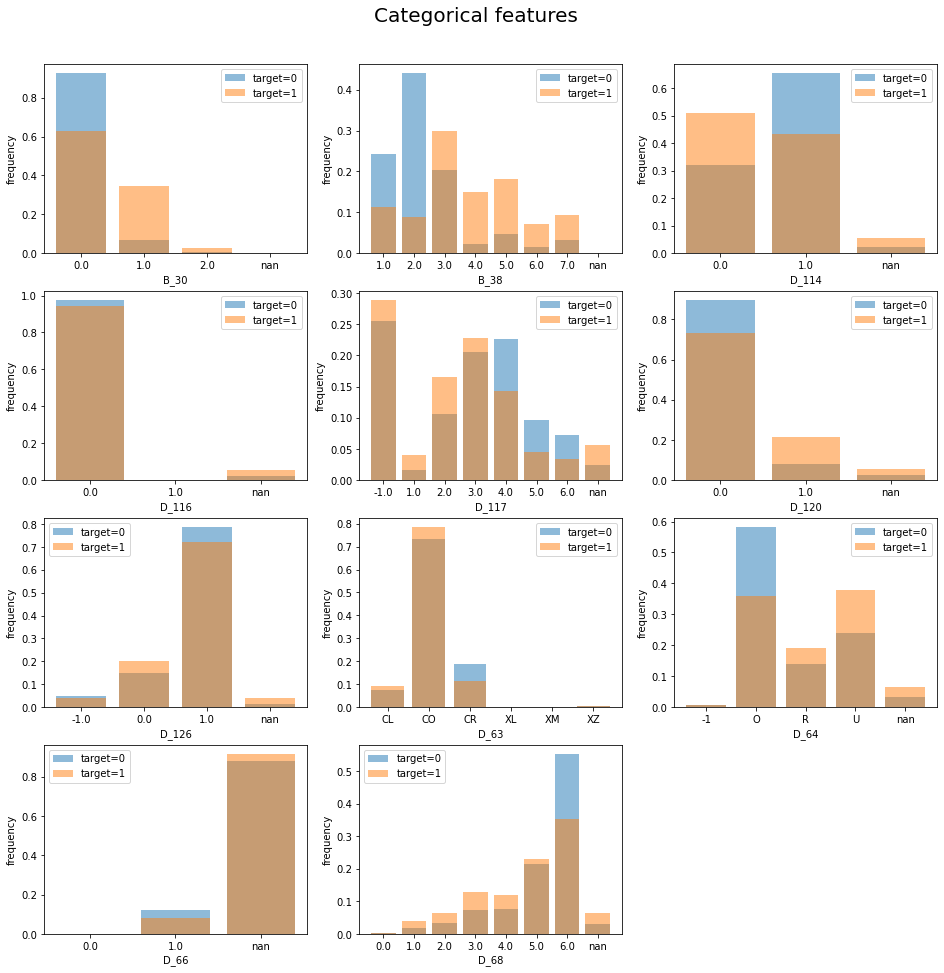

In [66]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
plt.figure(figsize=(16, 16))
for i, f in enumerate(cat_features):
    plt.subplot(4, 3, i+1)
    temp = pd.DataFrame(train[f][train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train[f][train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Categorical features', fontsize=20, y=0.93)
plt.show()
del temp

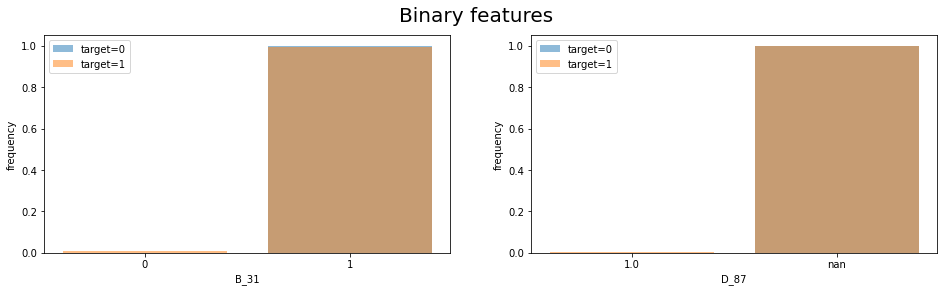

In [69]:
bin_features = ['B_31', 'D_87']
plt.figure(figsize=(16, 4))
for i, f in enumerate(bin_features):
    plt.subplot(1, 2, i+1)
    temp = pd.DataFrame(train[f][train.target == 0].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=0')
    temp = pd.DataFrame(train[f][train.target == 1].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
    temp.index.name = 'value'
    temp.reset_index(inplace=True)
    plt.bar(temp.index, temp['count'], alpha=0.5, label='target=1')
    plt.xlabel(f)
    plt.ylabel('frequency')
    plt.legend()
    plt.xticks(temp.index, temp.value)
plt.suptitle('Binary features', fontsize=20)
plt.show()
del temp

### 2.3 Numerical features

In [97]:
# generate columns
categorical_columns = cat_features + bin_features

delinquency_columns = [x for x in train.columns if x.startswith('D') and x not in categorical_columns]
spend_columns = [x for x in train.columns if x.startswith('S') and x != 'S_2' and x not in categorical_columns] # exclude datetime column
payment_columns = [x for x in train.columns if x.startswith('P') and x not in categorical_columns]
balance_columns = [x for x in train.columns if x.startswith('B') and x not in categorical_columns]
risk_columns = [x for x in train.columns if x.startswith('R') and x not in categorical_columns]
label = ['target']

# function to retrieve label & feature correlation
def calc_corr(df, columns):
    c_df = df[columns].corr()
    c_df = c_df.iloc[0].reset_index()
    c_df = c_df.iloc[1:]
    c_df.columns = ['col_name', 'corr']
    return c_df

### 2.3.1 delinquency column correlation

In [100]:
%%time
d_cols_corr = calc_corr(train, label + delinquency_columns)
d_cols_corr.head(3)

CPU times: user 1min 9s, sys: 2.29 s, total: 1min 12s
Wall time: 1min 12s


,col_name,corr
1,D_39,0.180007
2,D_41,0.246780
3,D_42,0.337734


CPU times: user 154 ms, sys: 8.25 ms, total: 163 ms
Wall time: 165 ms


<AxesSubplot:xlabel='col_name'>

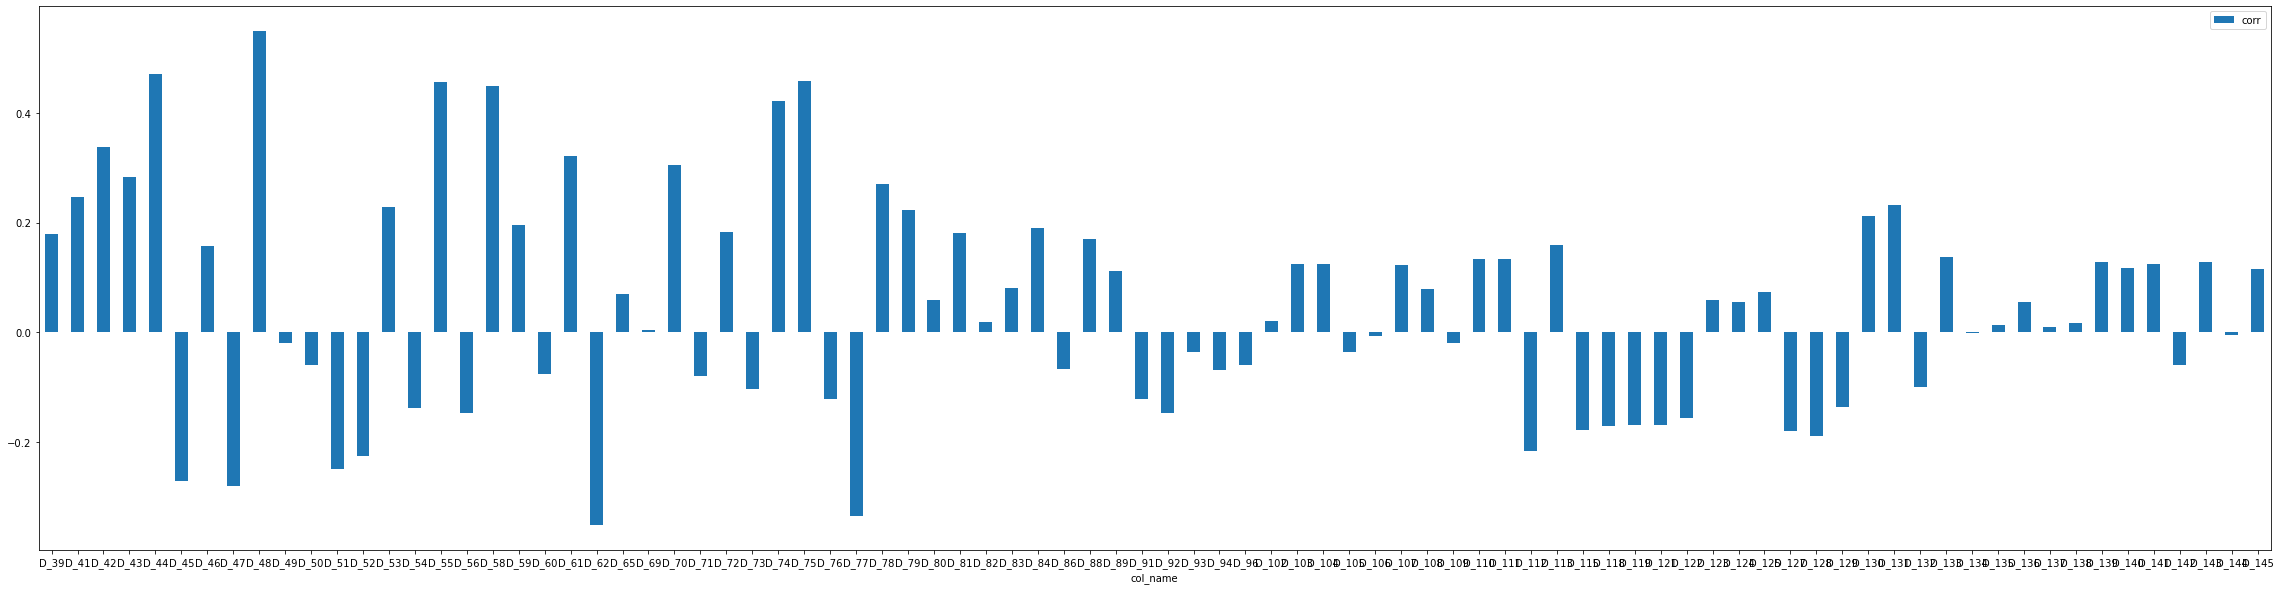

In [101]:
%%time
d_cols_corr.plot.bar(x='col_name', y='corr', rot=0, figsize=(40, 10))

### 2.3.2 Spend features

In [102]:
%%time
s_cols_corr = calc_corr(train, label + spend_columns)
s_cols_corr.head(3)

CPU times: user 5.99 s, sys: 661 ms, total: 6.65 s
Wall time: 7.14 s


,col_name,corr
1,S_3,0.323065
2,S_5,0.044759
3,S_6,-0.098949


CPU times: user 56 ms, sys: 3.18 ms, total: 59.2 ms
Wall time: 58.4 ms


<AxesSubplot:xlabel='col_name'>

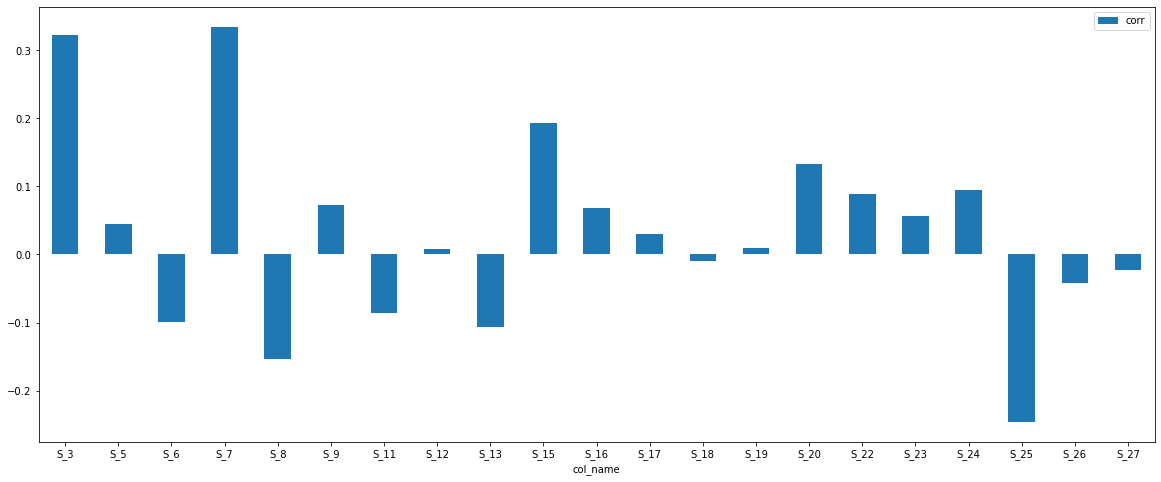

In [106]:
%%time
s_cols_corr.plot.bar(x='col_name', y='corr', rot=0, figsize=(20, 8))

### 2.3.3 payment_columns

In [107]:
%%time
p_cols_corr = calc_corr(train, label + payment_columns)
p_cols_corr.head(3)

CPU times: user 337 ms, sys: 99.1 ms, total: 436 ms
Wall time: 499 ms


,col_name,corr
1,P_2,-0.610765
2,P_3,-0.243743
3,P_4,0.237511


CPU times: user 32.5 ms, sys: 3.59 ms, total: 36.1 ms
Wall time: 33.6 ms


<AxesSubplot:xlabel='col_name'>

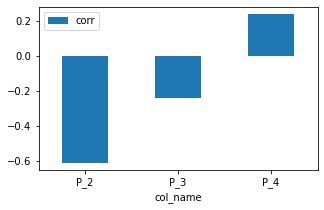

In [109]:
%%time
p_cols_corr.plot.bar(x='col_name', y='corr', rot=0, figsize=(5, 3))

### 2.3.4 balance_columns

In [110]:
%%time
b_cols_corr = calc_corr(train, label + balance_columns)
b_cols_corr.head(3)

CPU times: user 15.7 s, sys: 1.2 s, total: 16.9 s
Wall time: 17.5 s


,col_name,corr
1,B_1,0.389767
2,B_2,-0.483062
3,B_3,0.429695


CPU times: user 84.2 ms, sys: 4.25 ms, total: 88.5 ms
Wall time: 90.2 ms


<AxesSubplot:xlabel='col_name'>

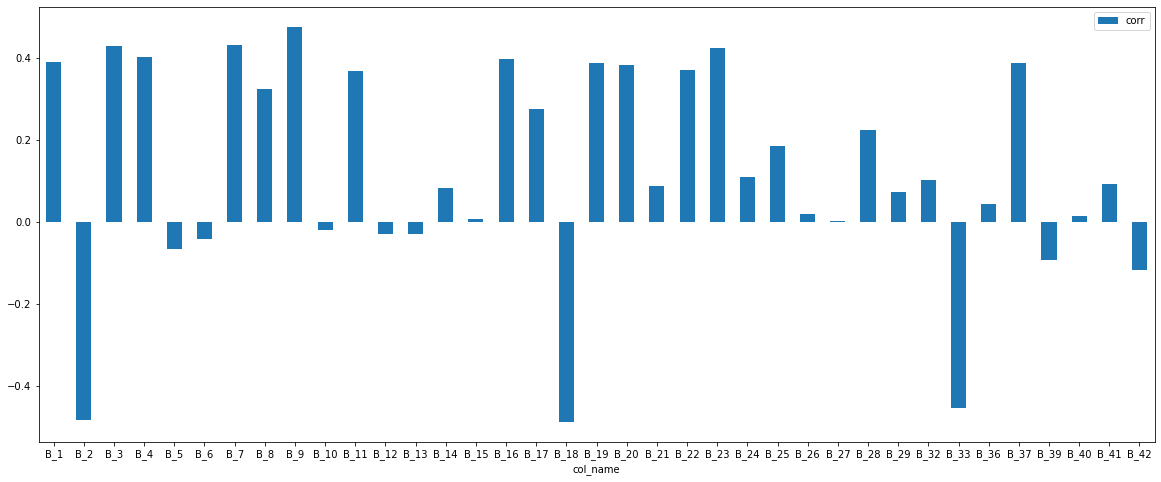

In [111]:
%%time
b_cols_corr.plot.bar(x='col_name', y='corr', rot=0, figsize=(20, 8))

### 2.3.5 risk_columns

In [113]:
%%time
r_cols_corr = calc_corr(train, label + risk_columns)
r_cols_corr.head(3)

CPU times: user 9.15 s, sys: 906 ms, total: 10.1 s
Wall time: 10.6 s


,col_name,corr
1,R_1,0.365000
2,R_2,0.263741
3,R_3,0.286787


CPU times: user 65.6 ms, sys: 4.25 ms, total: 69.8 ms
Wall time: 69 ms


<AxesSubplot:xlabel='col_name'>

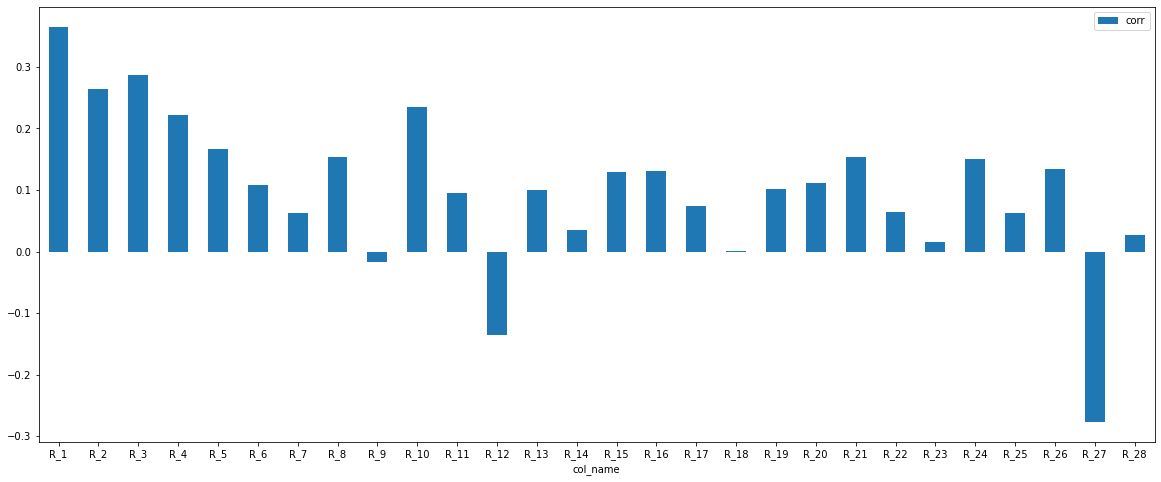

In [114]:
%%time
r_cols_corr.plot.bar(x='col_name', y='corr', rot=0, figsize=(20, 8))

### 2.3.6 Data anonymization

- https://www.kaggle.com/code/raddar/the-data-has-random-uniform-noise-added

/Users/qucy/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='B_2'>

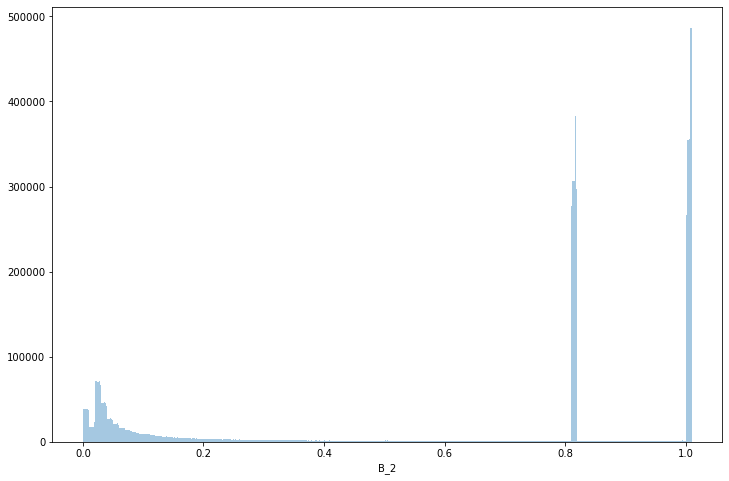

In [125]:
plt.figure(figsize=(12, 8))
sns.distplot(train['B_2'], bins=500, kde=False)

In [130]:
np.random.uniform(0, 0.01, 10)

array([0.00434983, 0.00101475, 0.00618667, 0.00545991, 0.00858624,
       0.00824118, 0.00488697, 0.00546897, 0.00199779, 0.00072632])